In [1]:
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import SkyCoord

from lsst.daf.butler import Butler
from lsst.rsp import get_tap_service
from lsst.source.injection import generate_injection_catalog
from lsst.source.injection import VisitInjectConfig, VisitInjectTask
from lsst.ip.diffim.subtractImages import AlardLuptonSubtractTask, AlardLuptonSubtractConfig

# Calexp from a cone region over a timespan

The first thing we do is to query the right images from an input cone region and time span.

In [2]:
target = SkyCoord('55.745834deg', '-32.269167deg', frame='icrs') 
err_radius_deg = 3.

tstop_mjd = 61_000
tstart_mjd = tstop_mjd - 7

In [3]:
# defines a few utilities we built in the last notebook..
def query_and_table(service, query):
    return service.search(query).to_table()


def table_summary(service, table_name: str):
    s = ""
    description = service.search(
        "SELECT description "
        "FROM tap_schema.tables "
        "WHERE tap_schema.tables.schema_name = 'dp02_dc2_catalogs'" 
        f"AND table_name = 'dp02_dc2_catalogs.{table_name}'"
    ).to_table().to_pandas().iloc[0]["description"]
    s += f"{table_name}: {description}\n\n"
    for i, row in service.search(
            "SELECT column_name, datatype, description, unit "
            "FROM tap_schema.columns "
            f"WHERE table_name = 'dp02_dc2_catalogs.{table_name}'"
        ).to_table().to_pandas().iterrows():
        s += f"{row.column_name}:  {row.description} ({row.datatype})\n"
    return s
        

def sregion_to_vertices(sregion: str, closed=True):
    """Convert the s_region from the ObsCore table into two
    arrays containing the x and y vertices, in order to plot
    boxes using matplotlib.

    from notebook DPO02_02c.
    """
    temp = sregion.split(' ')
    xvertices = []
    yvertices = []
    ix = 2
    iy = 3
    for c in range(4):
        xvertices.append(float(temp[ix]))
        yvertices.append(float(temp[iy]))
        ix += 2
        iy += 2
    if closed:
        xvertices.append(xvertices[0])
        yvertices.append(yvertices[0])
    return xvertices, yvertices


def circle_string(ra, dec, err_radius):
    return f"{ra:.4f}, {dec:.4f}, {err_radius:.4f}"


def query_obs_stdomain(service, tstart_mj, tstop_mj, ra, dec, err_radius, dp_subtype="lsst.calexp"):
    """
    Queries observation table for all pictures of type `dp_subtype` taken between 
    start_mj and stop_mj, with central spatial position falling in a circle centered
    at `ra`, `dec` with radius `err_radius`.
    """
    return query_and_table(
        service, 
        "SELECT *"
        "FROM ivoa.ObsCore "
        f"WHERE CONTAINS(POINT('ICRS', s_ra, s_dec), CIRCLE('ICRS', {circle_string(ra, dec, err_radius)}))=1 "
        f"AND t_min >= {tstart_mj} "
        f"AND t_min < {tstop_mj} "
        f"AND dataproduct_subtype = '{dp_subtype}'"
    ).to_pandas()


service = get_tap_service("tap")

For simplicity, we keep only images taken in the $r$ band.

In [4]:
calexp_all_df = query_obs_stdomain(service, tstart_mjd, tstop_mjd, target.ra.deg, target.dec.deg, err_radius_deg)
calexp_df = calexp_all_df[calexp_all_df["lsst_band"] == "r"]

In [5]:
calexp_df.head()

access_format  \
4   application/x-votable+xml;content=datalink   
6   application/x-votable+xml;content=datalink   
14  application/x-votable+xml;content=datalink   
15  application/x-votable+xml;content=datalink   
17  application/x-votable+xml;content=datalink   

                                           access_url  calib_level  \
4   https://data.lsst.cloud/api/datalink/links?ID=...            2   
6   https://data.lsst.cloud/api/datalink/links?ID=...            2   
14  https://data.lsst.cloud/api/datalink/links?ID=...            2   
15  https://data.lsst.cloud/api/datalink/links?ID=...            2   
17  https://data.lsst.cloud/api/datalink/links?ID=...            2   

   dataproduct_subtype dataproduct_type        em_max        em_min  \
4          lsst.calexp            image  6.910000e-07  5.520000e-07   
6          lsst.calexp            image  6.910000e-07  5.520000e-07   
14         lsst.calexp            image  6.910000e-07  5.520000e-07   
15         lsst.calexp            image  6.910000e-07  5.520000e-07   
17         lsst.calexp            image  6.910000e-07  5.520000e-07   

    em_res_power  em_xel facility_name  ...  \
4            NaN    <NA>    Rubin-LSST  ...   
6            NaN    <NA>    Rubin-LSST  ...   
14           NaN    <NA>    Rubin-LSST  ...   
15           NaN    <NA>    Rubin-LSST  ...   
17           NaN    <NA>    Rubin-LSST  ...   

                                             s_region s_resolution  s_xel1  \
4   POLYGON ICRS 53.058355 -31.234522 53.334874 -3...          NaN    <NA>   
6   POLYGON ICRS 58.512770 -32.303780 58.583346 -3...          NaN    <NA>   
14  POLYGON ICRS 52.327275 -32.232813 52.607407 -3...          NaN    <NA>   
15  POLYGON ICRS 54.029645 -31.411852 54.305597 -3...          NaN    <NA>   
17  POLYGON ICRS 52.486337 -31.929507 52.765432 -3...          NaN    <NA>   

    s_xel2 t_exptime         t_max         t_min  t_resolution t_xel  \
4     <NA>      30.0  60997.123928  60997.123581           NaN  <NA>   
6     <NA>      30.0  60996.169268  60996.168921           NaN  <NA>   
14    <NA>      30.0  60997.123928  60997.123581           NaN  <NA>   
15    <NA>      30.0  60997.123928  60997.123581           NaN  <NA>   
17    <NA>      30.0  60997.123928  60997.123581           NaN  <NA>   

   target_name  
4      UNKNOWN  
6      UNKNOWN  
14     UNKNOWN  
15     UNKNOWN  
17     UNKNOWN  

[5 rows x 37 columns]

# Selecting coordinates for the transient

We query for galaxies (as classified in the truth summary table) in a place of the cone region where multiple calexp overlap (host search field).

In [6]:
query = ("SELECT mt.id_truth_type AS mt_id_truth_type, "
        "mt.match_objectId AS mt_match_objectId, "
        "ts.ra AS ts_ra, "
        "ts.dec AS ts_dec, "
        "ts.mag_r AS ts_mag_r, "
        "ts.redshift AS ts_redshift, "
        "ts.flux_r AS ts_flux_r, "
        "obj.coord_ra AS obj_coord_ra, "
        "obj.coord_dec AS obj_coord_dec, "
        "obj.refExtendedness AS obj_refExtendedness, "
        "scisql_nanojanskyToAbMag(obj.r_cModelFlux) AS obj_cModelMag_r, "
        "obj.r_cModelFlux AS obj_r_cModelFlux "
        "FROM dp02_dc2_catalogs.MatchesTruth AS mt "
        "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "
        "JOIN dp02_dc2_catalogs.Object AS obj ON mt.match_objectId = obj.objectId "
        "WHERE CONTAINS(POINT('ICRS', obj.coord_ra, obj.coord_dec), CIRCLE('ICRS', 57.0, -34.0, 0.1)) = 1 "
        "AND ts.truth_type = 1 "
        "AND obj.detect_isPrimary = 1")

true_objects_df = query_and_table(service, query).to_pandas()

In [7]:
true_objects_df.head()

mt_id_truth_type    mt_match_objectId      ts_ra     ts_dec   ts_mag_r  \
0     5878376562_1  1821881971131824463  56.956575 -34.075202  27.470301   
1     5879950810_1  1821881971131856757  56.957269 -34.060944  27.436600   
2     5878622737_1  1821881971131822812  56.957020 -34.085744  27.928400   
3     5878038733_1  1821881971131824410  56.991282 -34.088519  27.383699   
4     5878038336_1  1821881971131856190  56.946833 -34.064126  28.051300   

   ts_redshift  ts_flux_r  obj_coord_ra  obj_coord_dec  obj_refExtendedness  \
0      1.15317  37.313400     56.956553     -34.075279                  0.0   
1      1.38818  38.492100     56.957296     -34.060928                  1.0   
2      1.18197  24.470501     56.957087     -34.085712                  0.0   
3      1.09076  40.412399     56.991218     -34.088538                  0.0   
4      1.07063  21.852400     56.946822     -34.064163                  1.0   

   obj_cModelMag_r  obj_r_cModelFlux  
0        27.345649         41.854330  
1        26.630754         80.853411  
2        26.913248         62.330513  
3        29.213388          7.492810  
4        26.616253         81.940507

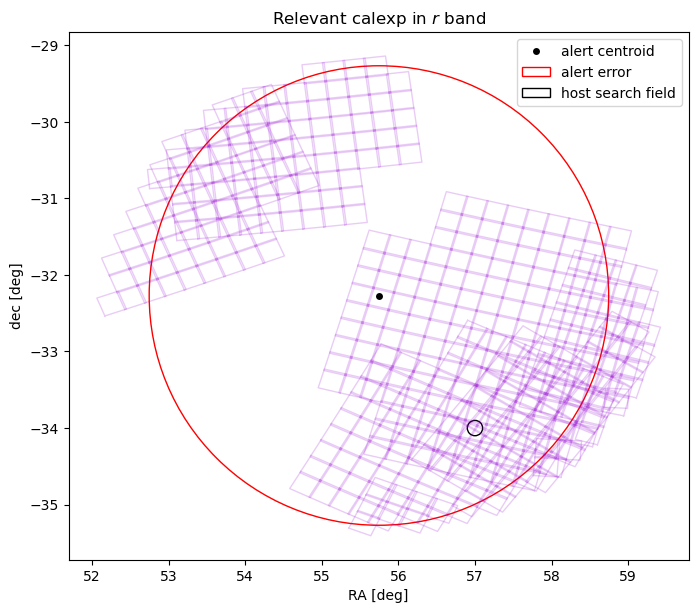

In [8]:
# run to visualize calexps in error region and host searchfield
circle_err = plt.Circle((target.ra.deg, target.dec.deg), err_radius_deg, color='r',  fill=False, label="alert error")
circle_interest_err = plt.Circle((57.0, -34.0), 0.1, color='black',  fill=False, label="host search field")

fig, ax = plt.subplots(figsize=(8, 8))
ax.axes.set_aspect('equal')
ax.plot(target.ra.deg, target.dec.deg, 'o', ms=5, mew=0, color='black', label="alert centroid")
ax.add_patch(circle_err)
ax.add_patch(circle_interest_err)
for i, row in calexp_df.iterrows():
    xvals, yvals = sregion_to_vertices(row['s_region'])
    ax.plot(xvals, yvals, lw=1, alpha=0.2, color='darkviolet')
ax.set_xlabel("RA [deg]")
ax.set_ylabel("dec [deg]")
plt.title("Relevant calexp in $r$ band")
plt.legend()
plt.show()

### Picking a host galaxy

Now we look through the object which were marked as extended object, and pick the r-brightest as our host galaxy candidate.

In [9]:
galhost = true_objects_df[
   true_objects_df["obj_refExtendedness"] == 1
].sort_values(by="obj_cModelMag_r").reset_index().iloc[0]
galhost

index                                 8989
mt_id_truth_type              5875000008_1
mt_match_objectId      1821943543782998521
ts_ra                            56.922304
ts_dec                          -33.948516
ts_mag_r                            13.125
ts_redshift                       0.017291
ts_flux_r                       20417800.0
obj_coord_ra                     56.922302
obj_coord_dec                   -33.948517
obj_refExtendedness                    1.0
obj_cModelMag_r                  14.712493
obj_r_cModelFlux            4731542.823588
Name: 0, dtype: object

These features look somewhat similiar to [NGC4993](https://en.wikipedia.org/wiki/NGC_4993), good.

Let's give a look to it. First we select all calexp which contains the candidate galaxy host. We write a helper function for this purpose.

In [10]:
from lsst.sphgeom import UnitVector3d, LonLat, ConvexPolygon

def sregion_contains(s_region: str, lon: float, lat: float) -> bool:
    """
    Checks if s_region polygon contains points at lon, lat coordinates (in degrees).
    """
    vertices = [
        UnitVector3d(LonLat.fromDegrees(lon, lat))
        for lon, lat in zip(*sregion_to_vertices(s_region, closed=False))
    ]
    polygon = ConvexPolygon(vertices)
    return polygon.contains(UnitVector3d(LonLat.fromDegrees(lon, lat)))

In [11]:
mask = [sregion_contains(s_region, galhost["obj_coord_ra"], galhost["obj_coord_dec"]) for s_region in calexp_df["s_region"]]
print(f"got {len(calexp_df[mask])} r-band exposure with s_region containing the candidate galaxy host.")

got 4 r-band exposure with s_region containing the candidate galaxy host.


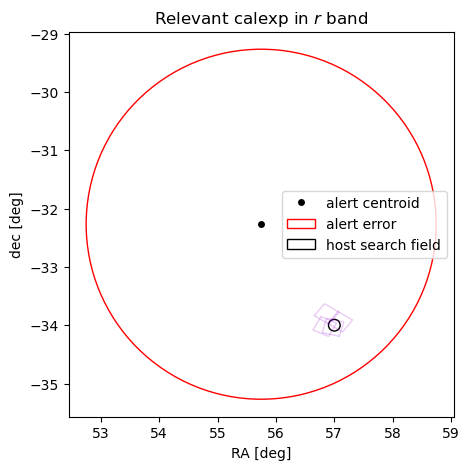

In [12]:
# run to visualize calexp in error region containing candidate hosts galaxy
circle_err = plt.Circle((target.ra.deg, target.dec.deg), err_radius_deg, color='r',  fill=False, label="alert error")
circle_interest_err = plt.Circle((57.0, -34.0), 0.1, color='black',  fill=False, label="host search field")

fig, ax = plt.subplots(figsize=(5, 5))
ax.axes.set_aspect('equal')
ax.plot(target.ra.deg, target.dec.deg, 'o', ms=5, mew=0, color='black', label="alert centroid")
ax.add_patch(circle_err)
ax.add_patch(circle_interest_err)
for i, row in calexp_df[mask].iterrows():
    xvals, yvals = sregion_to_vertices(row['s_region'])
    ax.plot(xvals, yvals, lw=1, alpha=0.2, color='darkviolet')
ax.set_xlabel("RA [deg]")
ax.set_ylabel("dec [deg]")
plt.title("Relevant calexp in $r$ band")
plt.legend()
plt.show()

[1/2] Downloading data from https://data.lsst.cloud/api/datalink/links?ID=butler%3A//dp02/43b98428-af4d-42d4-afc2-d801e11265d9..
[2/2] Plotting..


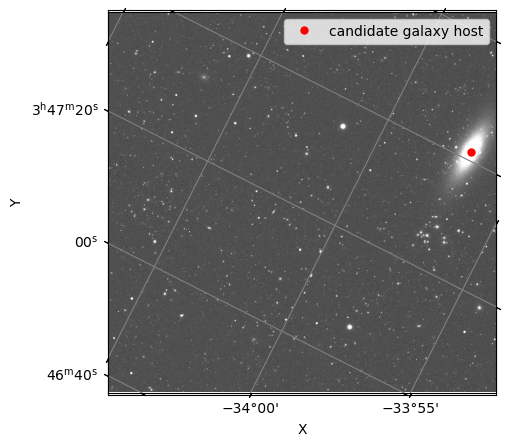

[1/2] Downloading data from https://data.lsst.cloud/api/datalink/links?ID=butler%3A//dp02/fc9c4603-acb1-42f7-a332-36452273a24f..
[2/2] Plotting..


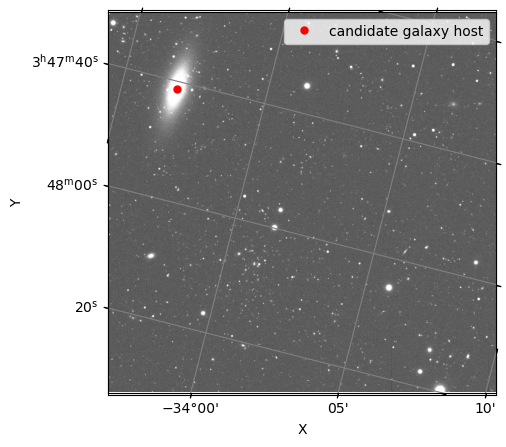

[1/2] Downloading data from https://data.lsst.cloud/api/datalink/links?ID=butler%3A//dp02/50180636-b7b9-435d-b6a3-536755c77164..
Skipping this image since it does not actually contain the candidate source, due to s_region padding.
[1/2] Downloading data from https://data.lsst.cloud/api/datalink/links?ID=butler%3A//dp02/74a5420f-2cc6-4c1f-9b07-b75e4151353d..
Skipping this image since it does not actually contain the candidate source, due to s_region padding.


In [13]:
# visualize the calexps containing the galaxy host
from pyvo.dal.adhoc import DatalinkResults
from astropy.io import fits
from astropy.wcs import WCS
import astropy.visualization as vis
from astropy import units as u

zscale = vis.ZScaleInterval()
urls = calexp_df[mask]["access_url"].values
coord_galhost = SkyCoord(
    ra = galhost["obj_coord_ra"] * u.degree, 
    dec = galhost["obj_coord_dec"] * u.degree, 
    frame='icrs'
)

for image_index, url in enumerate(urls):
    print(f"[1/2] Downloading data from {url}..")
    dl_results = DatalinkResults.from_result_url(url, session=service._session)
    image_url = dl_results['access_url'][0]
    image_data, image_hdr = fits.getdata(image_url, header=True)
    img_wcs = WCS(image_hdr)
    # calexps s_region have padding, and our region can fall in that. see tutorial notebook DP02_02c for more info
    if not img_wcs.footprint_contains(coord_galhost):
        print("Skipping this image since it does not actually contain the candidate source, due to s_region padding.")
        continue
    
    print("[2/2] Plotting..")
    fig, ax = plt.subplots(1, figsize=(5, 5))
    plt.subplot(projection=img_wcs)
    plt.plot(*img_wcs.world_to_pixel(coord_galhost), 'ro', ms=5, label="candidate galaxy host")
    plt.imshow(image_data, cmap='gray', **{k: v for k, v in  zip(["vmin", "vmax"], zscale.get_limits(image_data))})
    plt.axis('on'); ax.set_xticks([]); ax.set_yticks([]); plt.xlabel('X'); plt.ylabel('Y')
    plt.grid(color='grey', ls='solid')
    plt.legend()
    plt.show()

### Picking coordinates for simulated transient

Let's set true coordinates for the transient we are going to inject, and visualize them with the host galaxy.

In [14]:
coord_transient = SkyCoord(
    ra = galhost["obj_coord_ra"] * u.degree - (1.3 / 60) * u.degree,
    dec = galhost["obj_coord_dec"] * u.degree, 
    frame='icrs'
)

[1/2] Downloading data from https://data.lsst.cloud/api/datalink/links?ID=butler%3A//dp02/43b98428-af4d-42d4-afc2-d801e11265d9..
[2/2] Plotting..


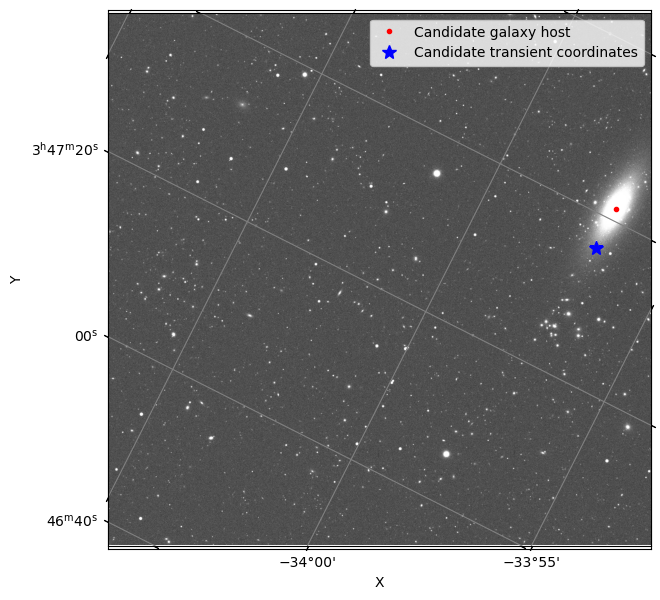

[1/2] Downloading data from https://data.lsst.cloud/api/datalink/links?ID=butler%3A//dp02/fc9c4603-acb1-42f7-a332-36452273a24f..
[2/2] Plotting..


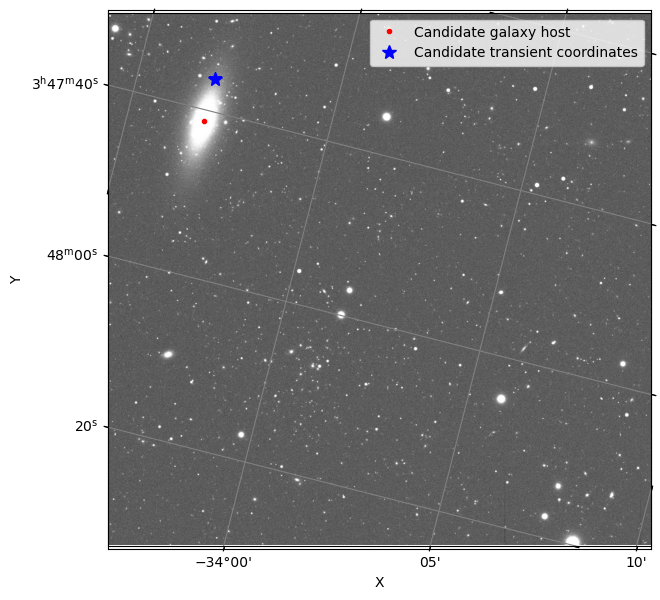

[1/2] Downloading data from https://data.lsst.cloud/api/datalink/links?ID=butler%3A//dp02/50180636-b7b9-435d-b6a3-536755c77164..
Skipping this image since it does not actually contain the candidate source, due to s_region padding.
[1/2] Downloading data from https://data.lsst.cloud/api/datalink/links?ID=butler%3A//dp02/74a5420f-2cc6-4c1f-9b07-b75e4151353d..
[2/2] Plotting..


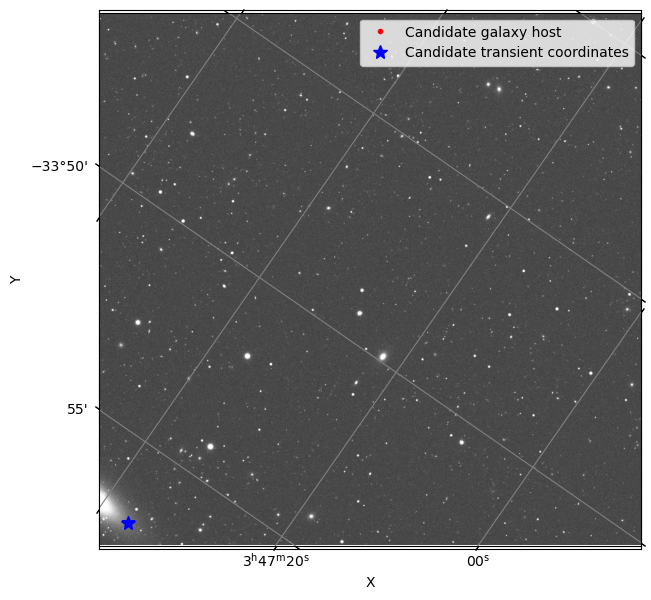

In [15]:
# shows the calexp containing the transient
from pyvo.dal.adhoc import DatalinkResults
from astropy.io import fits
from astropy.wcs import WCS
import astropy.visualization as vis
from astropy import units as u

zscale = vis.ZScaleInterval()
urls = calexp_df[mask]["access_url"].values

for image_index, url in enumerate(urls):
    print(f"[1/2] Downloading data from {url}..")
    dl_results = DatalinkResults.from_result_url(url, session=service._session)
    image_url = dl_results['access_url'][0]
    image_data, image_hdr = fits.getdata(image_url, header=True)
    img_wcs = WCS(image_hdr)
    # calexps s_region have padding, and our region can fall in that. see tutorial notebook DP02_02c for more info
    if not img_wcs.footprint_contains(coord_transient):
        print("Skipping this image since it does not actually contain the candidate source, due to s_region padding.")
        continue
    
    print("[2/2] Plotting..")
    fig, ax = plt.subplots(1, figsize=(7, 7))
    plt.subplot(projection=img_wcs)
    plt.plot(*img_wcs.world_to_pixel(coord_galhost), 'ro', ms=3, label="Candidate galaxy host")
    plt.plot(*img_wcs.world_to_pixel(coord_transient), 'b*', ms=10, label="Candidate transient coordinates")
    plt.imshow(image_data, cmap='gray', **{k: v for k, v in  zip(["vmin", "vmax"], zscale.get_limits(image_data))})
    plt.axis('on'); ax.set_xticks([]); ax.set_yticks([]); plt.xlabel('X'); plt.ylabel('Y')
    plt.grid(color='grey', ls='solid')
    plt.legend()
    plt.show()

# Source injection

The goal is now to inject a single point source at the transient's location over all the calexps we recovered.

### Injecting on single calibrated exposure

Let's start by injecting onto a single image. We will inject a point-like source with a magnitude similiar to the one observed for the 170817 afterglow.

In [16]:
def parse_calexp_dict(row: pd.Series):
    return {
        "instrument": row["instrument_name"],
        "detector": int(row["lsst_detector"]),
        "visit": int(row["lsst_visit"]),
        "band": row["lsst_band"],
        "physical_filter": row["lsst_filter"],
    }


butler = Butler('dp02', collections='2.2i/runs/DP0.2')
calexp = butler.get("calexp", dataId=parse_calexp_dict(calexp_df[mask].iloc[0]))

In [17]:
def _inject_star_source(calexp, ra, dec, mag):
    EPSILON = 10**-7
    injection_catalog = generate_injection_catalog(
        ra_lim=[ra, ra + EPSILON],
        dec_lim=[dec, dec + EPSILON],
        number=1,
        source_type="Star",
        mag=[mag],
    )
    inject_config = VisitInjectConfig()
    inject_task = VisitInjectTask(config=inject_config)
    injected_output = inject_task.run(
        injection_catalogs=injection_catalog,
        input_exposure=calexp.clone(),
        psf=calexp.getPsf(),
        photo_calib=calexp.getPhotoCalib(),
        wcs=calexp.getWcs(),
    )
    return injected_output.output_exposure, injected_output.output_catalog


calexp_injected, calexp_catalog = _inject_star_source(calexp, coord_transient.ra.deg, coord_transient.dec.deg, 17.)

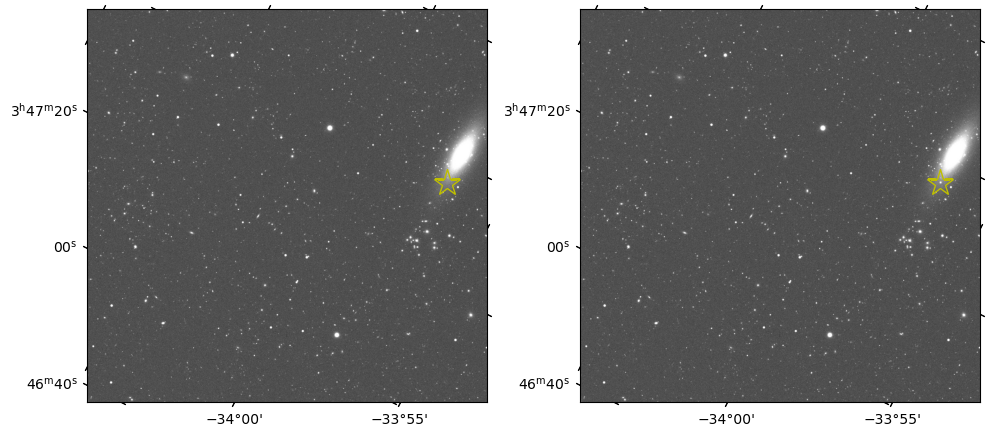

In [18]:
# visualize base calexp and injected image
from pyvo.dal.adhoc import DatalinkResults
from astropy.io import fits
from astropy.wcs import WCS
import astropy.visualization as vis
from astropy import units as u

zscale = vis.ZScaleInterval()

fig = plt.figure(figsize=(10, 5))
for i, image in enumerate([calexp, calexp_injected]):
    wcs = WCS(image.getWcs().getFitsMetadata())
    image_data = image.getImage().array
    limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}

    ax = fig.add_subplot(1, 2, i+1, projection=wcs)
    ax.imshow(image_data, cmap='gray', **limits)
    ax.plot(*wcs.world_to_pixel(coord_transient), 'y*', markerfacecolor="None", ms=20, label="Candidate transient coordinates")
    ax.set_xticks([]); ax.set_yticks([]); ax.set_xlabel(''); ax.set_ylabel('')
plt.tight_layout()
plt.show()

### Injecting on multiple images

Let's repeat injection onto all the calexps we got for our cone regione and timespan.

In [19]:
def inject_star_source(calexp_df: pd.DataFrame, coord: SkyCoord, mag: float):
    butler = Butler("dp02", collections="2.2i/runs/DP0.2")
    output = []
    for i, row in calexp_df.iterrows():
        dataId = parse_calexp_dict(row)
        image = butler.get("calexp", dataId=dataId)
        if not image.containsSkyCoords(coord_transient.ra, coord_transient.dec):
            continue
        output.append((*_inject_star_source(image, coord.ra.deg, coord.dec.deg, mag), image, dataId))
    return output

injected_calexps, injection_catalogs, calexps, dataIds = zip(*inject_star_source(calexp_df[mask], coord_transient, 17))

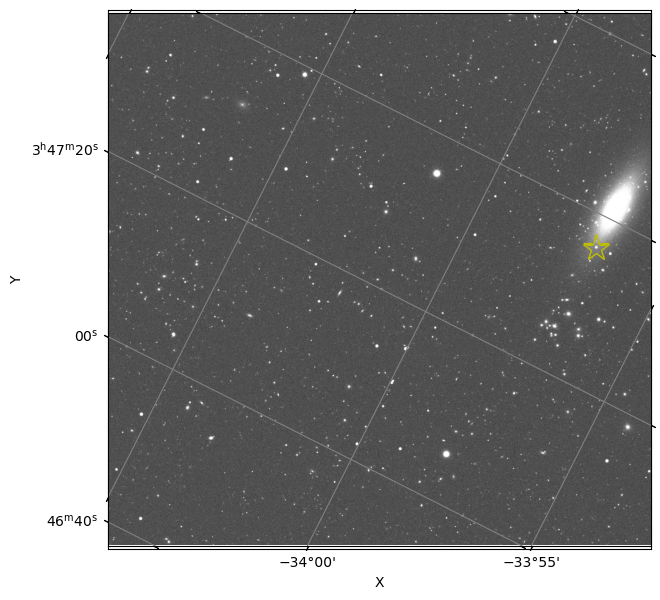

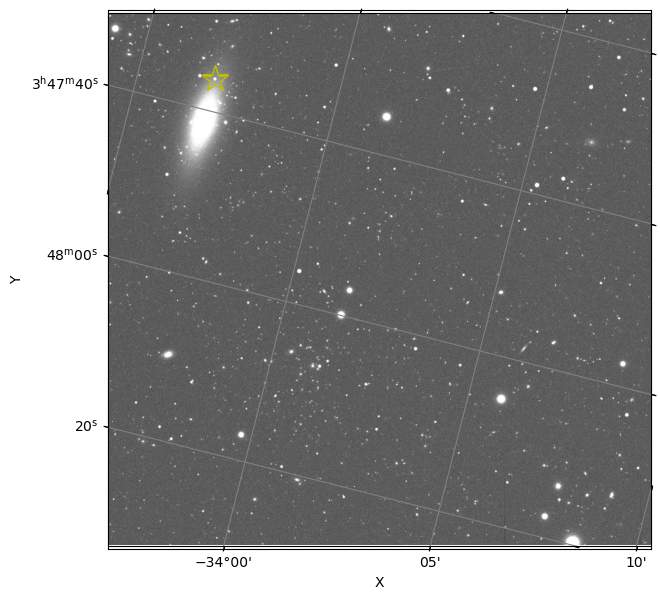

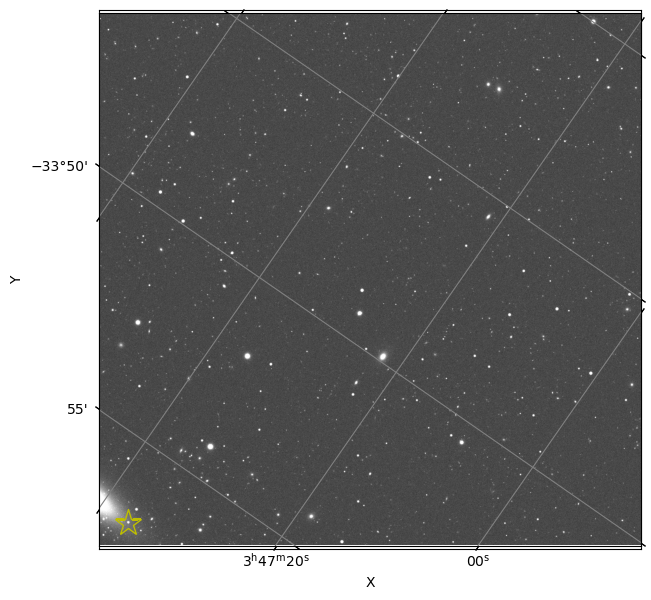

In [20]:
# plots all images with injected source
for image in injected_calexps:
    zscale = vis.ZScaleInterval()
    wcs = WCS(image.getWcs().getFitsMetadata())
    image_data = image.getImage().array
    
    fig, ax = plt.subplots(1, figsize=(7, 7))
    plt.subplot(projection=wcs)
    limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}
    plt.imshow(image_data, cmap='gray', **limits)
    plt.plot(*wcs.world_to_pixel(coord_transient), 'y*', markerfacecolor="None", ms=20, label="Candidate transient coordinates")
    plt.axis('on'); ax.set_xticks([]); ax.set_yticks([]); plt.xlabel('X'); plt.ylabel('Y')
    plt.grid(color='grey', ls='solid')
    plt.show()

# Source subtraction

Finally we show how difference images are obtained for one of our injected images.

In [21]:
dataId = parse_calexp_dict(calexp_df[mask].iloc[0])
sources = butler.get('src', dataId=dataId)
template = butler.get("goodSeeingDiff_templateExp", dataId=dataId)

config = AlardLuptonSubtractConfig()
config.sourceSelector.value.unresolved.name = 'base_ClassificationExtendedness_value'
alTask = AlardLuptonSubtractTask(config=config)
result = alTask.run(template, calexp_injected, sources)

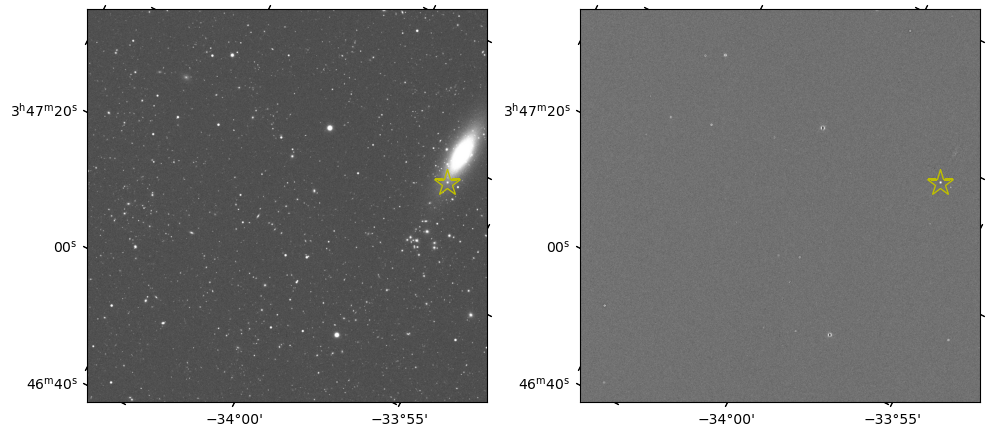

In [22]:
# visualize the injected and difference image
from pyvo.dal.adhoc import DatalinkResults
from astropy.io import fits
from astropy.wcs import WCS
import astropy.visualization as vis
from astropy import units as u

zscale = vis.ZScaleInterval()

fig = plt.figure(figsize=(10, 5))
for i, image in enumerate([calexp_injected, result.difference]):
    wcs = WCS(image.getWcs().getFitsMetadata())
    image_data = image.getImage().array
    limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}

    ax = fig.add_subplot(1, 2, i+1, projection=wcs)
    ax.imshow(image_data, cmap='gray', **limits)
    ax.plot(*wcs.world_to_pixel(coord_transient), 'y*', markerfacecolor="None", ms=20, label="Candidate transient coordinates")
    ax.set_xticks([]); ax.set_yticks([]); ax.set_xlabel(''); ax.set_ylabel('')
plt.tight_layout()
plt.show()

Finally we repeat for all the injected images.

In [23]:
def subtract(calexps, dataIds):
    output = []
    for calexp, dataId in zip(calexps, dataIds):
        sources = butler.get('src', dataId=dataId)
        template = butler.get("goodSeeingDiff_templateExp", dataId=dataId)
        config = AlardLuptonSubtractConfig()
        config.sourceSelector.value.unresolved.name = 'base_ClassificationExtendedness_value'
        alTask = AlardLuptonSubtractTask(config=config)
        output.append(alTask.run(template, calexp, sources).difference)
    return output


In [24]:
differences = subtract(injected_calexps, dataIds)

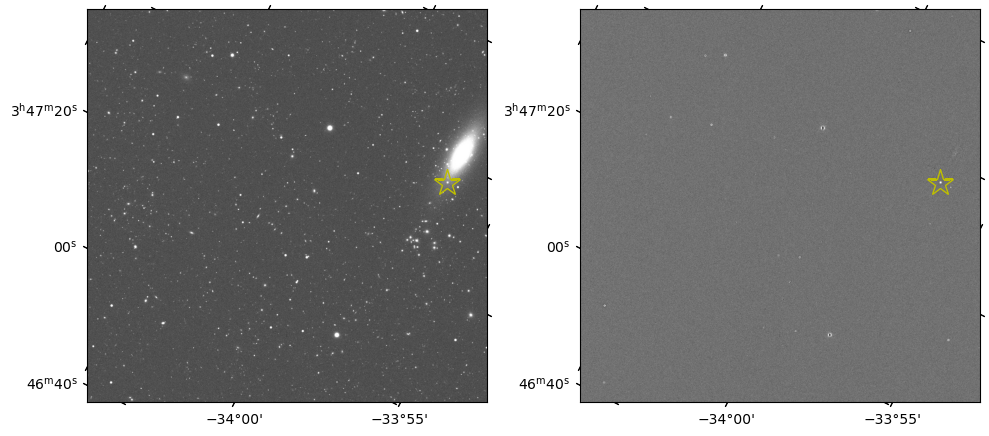

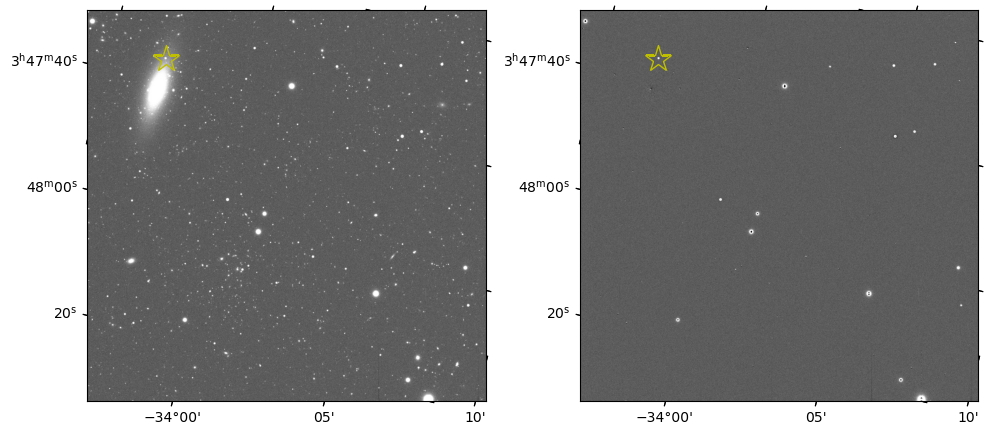

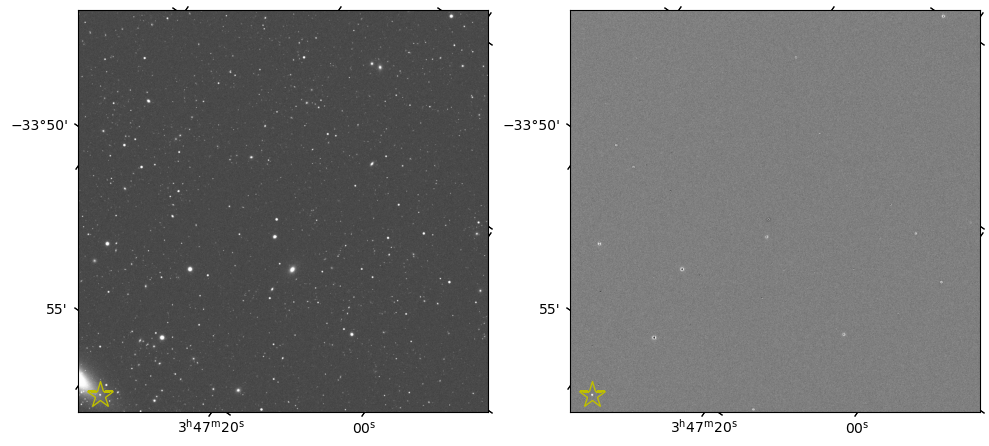

In [25]:
# visualize the injected and difference images
from pyvo.dal.adhoc import DatalinkResults
from astropy.io import fits
from astropy.wcs import WCS
import astropy.visualization as vis
from astropy import units as u

zscale = vis.ZScaleInterval()


for images in zip(injected_calexps, differences):
    fig = plt.figure(figsize=(10, 5))
    for i, image in enumerate(images):
        wcs = WCS(image.getWcs().getFitsMetadata())
        image_data = image.getImage().array
        limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}
    
        ax = fig.add_subplot(1, 2, i+1, projection=wcs)
        ax.imshow(image_data, cmap='gray', **limits)
        ax.plot(*wcs.world_to_pixel(coord_transient), 'y*', markerfacecolor="None", ms=20, label="Candidate transient coordinates")
        ax.set_xticks([]); ax.set_yticks([]); ax.set_xlabel(''); ax.set_ylabel('')
    plt.tight_layout()
    plt.show()

# Conclusions

We learned how to inject sources on galaxy hosts in a cone region, and to subtract templates to these images. In the next episodes w